In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# miniFraudfinder - XGBoost Model Experimentation



## Overview

[miniFraudFinder](https://github.com/jrdetorre-google/minifraudfinder) is a series of labs on how to build a  fraud detection system on Google Cloud. Throughout the miniFraudFinder labs, you will learn how to read historical bank transaction data stored in data warehouse,  perform exploratory data analysis (EDA), do feature engineering,  train a model u, register your model in a model registry, evaluate your model, deploy your model to an endpoint, do real-time inference on your model and monitor your model.

### Objective

This notebook shows how to pull features from Feature Store for training, run data exploratory analysis on features, build a machine learning model locally, experiment with various hyperparameters, evaluate the model and deploy it to a Vertex AI endpoint. 

This lab uses the following Google Cloud services and resources:

- [Vertex AI](https://cloud.google.com/vertex-ai/)
- [BigQuery](https://cloud.google.com/bigquery/)

Steps performed in this notebook:

- Pull training data from BigQuery
- Do some exploratory analysis on the extracted data
- Train the model and track the results using Vertex AI Experiments

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* BigQuery

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [BigQuery pricing](https://cloud.google.com/bigquery/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Load configuration settings from the setup notebook

Set the constants used in this notebook and load the config settings from the `00_environment_setup.ipynb` notebook.

In [16]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
BUCKET_NAME = f"{PROJECT_ID}-fraudfinder"
config = !gsutil cat gs://{BUCKET_NAME}/config/notebook_env.py
print(config.n)
exec(config.n)


BUCKET_NAME          = "orange-ml-demo-fraudfinder"
PROJECT              = "orange-ml-demo"
REGION               = "us-central1"
ID                   = "zv7r3"
FEATURESTORE_ID      = "fraudfinder_zv7r3"
MODEL_NAME           = "ff_model"
ENDPOINT_NAME        = "ff_model_endpoint"
TRAINING_DS_SIZE     = "1000"



### Import libraries

In [17]:
# General
import os
import sys
from typing import Union, List
import random
from datetime import datetime, timedelta
import time
import json
import logging

from google.cloud import aiplatform as vertex_ai


# Data Preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Model Training
from google.cloud import bigquery
from google.cloud import storage
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

### Define constants

In [26]:
# General
DATA_DIR = os.path.join(os.pardir, "data")
DATA_URI = f"gs://{BUCKET_NAME}/data"
TRAIN_DATA_URI = f"{DATA_URI}/train"

# Feature Store
START_DATE_TRAIN = (datetime.today() - timedelta(days=30)).strftime("%Y-%m-%d")
END_DATE_TRAIN = (datetime.today() - timedelta(days=20)).strftime("%Y-%m-%d")
CUSTOMER_ENTITY = "customer_entity"
TERMINAL_ENTITY = "terminal_entity"


# Training
COLUMNS_IGNORE = [
    "terminal_id",
    "customer_id",
    "entity_type_event",
    "entity_type_customer",
    "entity_type_terminal",
]
TARGET = "tx_fraud"

# Custom Training
MODEL_NAME = f"{MODEL_NAME}_xgb_exp_{ID}"

# Experiment
EXPERIMENT_NAME = f"ff-experiment-{ID}"

### Initialize clients
Next you have to initialize the [Vertex AI SDK](https://cloud.google.com/vertex-ai/docs/start/use-vertex-ai-python-sdk) and the Python BigQuery Client for your project, region and corresponding bucket.

In [19]:
bq_client = bigquery.Client(project=PROJECT_ID, location=REGION)

In [20]:
vertex_ai.init(
    project=PROJECT_ID,
    location=REGION,
    staging_bucket=BUCKET_NAME,
    experiment=EXPERIMENT_NAME,
)

### Helper Functions
Next you will create a helper function for sending queries to BigQuery.

In [21]:
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Run a BigQuery query and return the job ID or result as a DataFrame
    Args:
        sql: SQL query, as a string, to execute in BigQuery
    Returns:
        df: DataFrame of results from query, or error, if any
    """

    bq_client = bigquery.Client()

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df


def create_gcs_dataset(client, display_name: str, gcs_source: Union[str, List[str]]):
    """
    A function to create a Vertex AI Dataset resource
    Args:
        client: Vertex AI Client instance
        display_name: The name of Vertex AI Dataset resource
        gcs_source: The URI of data on the bucket
    Returns:
        Vertex AI Dataset resource
    """
    dataset = client.TabularDataset.create(
        display_name=display_name,
        gcs_source=gcs_source,
    )

    dataset.wait()
    return dataset


def preprocess(df: pd.DataFrame):
    """
    Converts categorical features to numeric. Removes unused columns.
    Args:
      df: Pandas df with raw data
    Returns:
      df with preprocessed data
    """
    df = df.drop(columns=UNUSED_COLUMNS)

    # Drop rows with NaN"s
    df = df.dropna()

    # Convert integer valued (numeric) columns to floating point
    numeric_columns = df.select_dtypes(["int32", "float32", "float64"]).columns
    df[numeric_columns] = df[numeric_columns].astype("float32")

    dummy_columns = list(df.dtypes[df.dtypes == "category"].index)
    df = pd.get_dummies(df, columns=dummy_columns)

    return df

## Fetching feature values for model training

To fetch the feature values from Feature Store as part of the training data, we have to specify the following inputs to define what we want to use to lookup the values in Feature Store:

- a file containing a table, with the entities and timestamps for each label
- a list of features to fetch values for
- the destination location and format


### Read-instance list

In our case, we need a csv file with content formatted like the table below:

|customer                     |terminal|timestamp                                    |
|-----------------------------|--------|---------------------------------------------|
|xxx3859                         |xxx8811    |2021-07-07 00:01:10 UTC                      |
|xxx4165                         |xxx8810    |2021-07-07 00:01:55 UTC                      |
|xxx2289                         |xxx2081    |2021-07-07 00:02:12 UTC                      |
|xxx3227                         |xxx3011    |2021-07-07 00:03:23 UTC                      |
|xxx2819                         |xxx6263    |2021-07-07 00:05:30 UTC                      |

where the column names are the names of entities in Feature Store and the timestamps represents the time an event occurred.

In [22]:
read_instances_query = f"""
    SELECT
        raw_tx.TX_TS AS timestamp,
        raw_tx.CUSTOMER_ID AS customer_entity,
        raw_tx.TERMINAL_ID AS terminal_entity,
        raw_tx.TX_AMOUNT AS tx_amount,
        raw_lb.TX_FRAUD AS tx_fraud,
    FROM 
        tx.tx as raw_tx
    LEFT JOIN 
        tx.txlabels as raw_lb
    ON raw_tx.TX_ID = raw_lb.TX_ID
    WHERE
        DATE(raw_tx.TX_TS) = "{START_DATE_TRAIN}";
"""
print(read_instances_query)

query_df = run_bq_query(read_instances_query)
query_df.head(4)


    SELECT
        raw_tx.TX_TS AS timestamp,
        raw_tx.CUSTOMER_ID AS customer_entity,
        raw_tx.TERMINAL_ID AS terminal_entity,
        raw_tx.TX_AMOUNT AS tx_amount,
        raw_lb.TX_FRAUD AS tx_fraud,
    FROM 
        tx.tx as raw_tx
    LEFT JOIN 
        tx.txlabels as raw_lb
    ON raw_tx.TX_ID = raw_lb.TX_ID
    WHERE
        DATE(raw_tx.TX_TS) = "2023-12-14";

Finished job_id: 1a6373c6-e39a-4ac1-b6b0-fdd5284bf7bf


,timestamp,customer_entity,terminal_entity,tx_amount,tx_fraud
0,2023-12-14 17:58:32+00:00,3067754972043832,00064542,75.140000000,0
1,2023-12-14 19:20:36+00:00,0760254201429742,00112824,188.980000000,1
2,2023-12-14 13:10:38+00:00,5512279691403134,00173725,30.690000000,0
3,2023-12-14 05:44:15+00:00,4331496243869536,00433749,52.600000000,0


In [28]:
feat_gen_query = f"""
 CREATE OR REPLACE TABLE tx.features_train_{START_DATE_TRAIN.replace("-","")} AS
 SELECT
        raw_tx.TX_TS AS timestamp,
        raw_tx.CUSTOMER_ID AS customer_entity,
        raw_tx.TERMINAL_ID AS terminal_entity,
        raw_tx.TX_AMOUNT AS tx_amount,
        raw_lb.TX_FRAUD AS tx_fraud,
        customers_{START_DATE_TRAIN.replace("-","")}.customer_id_nb_tx_1day_window,
        customers_{START_DATE_TRAIN.replace("-","")}.customer_id_nb_tx_7day_window,
        customers_{START_DATE_TRAIN.replace("-","")}.customer_id_nb_tx_14day_window,
        customers_{START_DATE_TRAIN.replace("-","")}.customer_id_avg_amount_1day_window,
        customers_{START_DATE_TRAIN.replace("-","")}.customer_id_avg_amount_7day_window,
        customers_{START_DATE_TRAIN.replace("-","")}.customer_id_avg_amount_14day_window,
        terminals_{START_DATE_TRAIN.replace("-","")}.terminal_id,
        terminals_{START_DATE_TRAIN.replace("-","")}.terminal_id_nb_tx_1day_window,
        terminals_{START_DATE_TRAIN.replace("-","")}.terminal_id_nb_tx_7day_window,
        terminals_{START_DATE_TRAIN.replace("-","")}.terminal_id_nb_tx_14day_window,
        terminals_{START_DATE_TRAIN.replace("-","")}.terminal_id_risk_1day_window,
        terminals_{START_DATE_TRAIN.replace("-","")}.terminal_id_risk_7day_window,
        terminals_{START_DATE_TRAIN.replace("-","")}.terminal_id_risk_14day_window  
    FROM 
        tx.tx as raw_tx
    LEFT JOIN 
        tx.txlabels as raw_lb
   ON raw_tx.TX_ID = raw_lb.TX_ID
    
    JOIN tx.customers_{START_DATE_TRAIN.replace("-","")}
    ON raw_tx.CUSTOMER_ID = customers_{START_DATE_TRAIN.replace("-","")}.CUSTOMER_ID
    
    JOIN tx.terminals_{START_DATE_TRAIN.replace("-","")}
    ON raw_tx.TERMINAL_ID = terminals_{START_DATE_TRAIN.replace("-","")}.TERMINAL_ID
    
    WHERE
        DATE(raw_tx.TX_TS) = "{START_DATE_TRAIN}";
"""

In [29]:
print(feat_gen_query)

run_bq_query(feat_gen_query)


 CREATE OR REPLACE TABLE tx.features_train_20231224 AS
 SELECT
        raw_tx.TX_TS AS timestamp,
        raw_tx.CUSTOMER_ID AS customer_entity,
        raw_tx.TERMINAL_ID AS terminal_entity,
        raw_tx.TX_AMOUNT AS tx_amount,
        raw_lb.TX_FRAUD AS tx_fraud,
        customers_20231224.customer_id_nb_tx_1day_window,
        customers_20231224.customer_id_nb_tx_7day_window,
        customers_20231224.customer_id_nb_tx_14day_window,
        customers_20231224.customer_id_avg_amount_1day_window,
        customers_20231224.customer_id_avg_amount_7day_window,
        customers_20231224.customer_id_avg_amount_14day_window,
        terminals_20231224.terminal_id,
        terminals_20231224.terminal_id_nb_tx_1day_window,
        terminals_20231224.terminal_id_nb_tx_7day_window,
        terminals_20231224.terminal_id_nb_tx_14day_window,
        terminals_20231224.terminal_id_risk_1day_window,
        terminals_20231224.terminal_id_risk_7day_window,
        terminals_20231224.terminal_i

""


In [30]:
read_features_query = f"""
SELECT *
FROM 
    tx.features_train_{START_DATE_TRAIN.replace("-","")}
TABLESAMPLE SYSTEM (0.1 PERCENT)

"""
print(read_features_query)

query_df_features = run_bq_query(read_features_query)
query_df_features.head(4)


SELECT *
FROM 
    tx.features_train_20231224
TABLESAMPLE SYSTEM (0.1 PERCENT)


Finished job_id: fe032272-9678-4959-a596-fffd28b78425


,timestamp,customer_entity,terminal_entity,tx_amount,tx_fraud,customer_id_nb_tx_1day_window,customer_id_nb_tx_7day_window,customer_id_nb_tx_14day_window,customer_id_avg_amount_1day_window,customer_id_avg_amount_7day_window,customer_id_avg_amount_14day_window,terminal_id,terminal_id_nb_tx_1day_window,terminal_id_nb_tx_7day_window,terminal_id_nb_tx_14day_window,terminal_id_risk_1day_window,terminal_id_risk_7day_window,terminal_id_risk_14day_window
0,2023-12-24 02:41:15+00:00,5583192019717152,22162485,85.010000000,0,6,36,60,67.795000,71.010000,72.074667,22162485,7,7,7,0.000000,0.00000,0.00000
1,2023-12-24 02:25:09+00:00,8777253978735382,63620340,337.430000000,1,27,40,71,342.389259,310.915750,226.112535,63620340,2,2,2,0.000000,0.00000,0.00000
2,2023-12-24 22:26:59+00:00,9688540057350561,48665363,7.090000000,0,13,64,64,11.677692,20.468750,20.468750,48665363,7,7,7,0.000000,0.00000,0.00000
3,2023-12-24 22:23:03+00:00,9186226544712325,01690402,84.570000000,0,3,31,57,72.226667,71.206129,69.356667,01690402,34,151,151,0.117647,0.02649,0.02649


#### Examine the label distribution
Let's create a plot and do an actual count of the values (fraud vs. non-fraud).

<Axes: title={'center': 'Count of transactions by fraud label (tx_fraud = 0 or 1)'}, xlabel='tx_fraud', ylabel='count'>

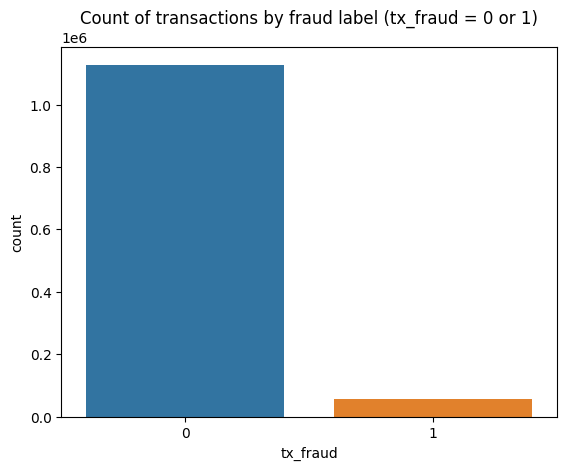

In [31]:
plt.title("Count of transactions by fraud label (tx_fraud = 0 or 1)")
sns.countplot(x="tx_fraud", data=query_df_features)

In [32]:
(query_df.tx_fraud.value_counts() / query_df.shape[0]) * 100

tx_fraud
0    98.124673
1     1.875327
Name: count, dtype: float64

As we can see the data is imbalanced. We will fix this later in this notebook before building the model.

#### Get a better understanding of the feature distributions using histograms
Now you can do the same for the input features. It's good to plot the distributions of our features to get a better understanding of them. 

array([[<Axes: title={'center': 'customer_id_nb_tx_1day_window'}>,
        <Axes: title={'center': 'customer_id_nb_tx_7day_window'}>,
        <Axes: title={'center': 'customer_id_nb_tx_14day_window'}>],
       [<Axes: title={'center': 'customer_id_avg_amount_1day_window'}>,
        <Axes: title={'center': 'customer_id_avg_amount_7day_window'}>,
        <Axes: title={'center': 'customer_id_avg_amount_14day_window'}>],
       [<Axes: title={'center': 'terminal_id_risk_1day_window'}>,
        <Axes: title={'center': 'terminal_id_risk_7day_window'}>,
        <Axes: title={'center': 'terminal_id_risk_14day_window'}>],
       [<Axes: title={'center': 'terminal_id_nb_tx_1day_window'}>,
        <Axes: title={'center': 'terminal_id_nb_tx_7day_window'}>,
        <Axes: title={'center': 'terminal_id_nb_tx_14day_window'}>]],
      dtype=object)

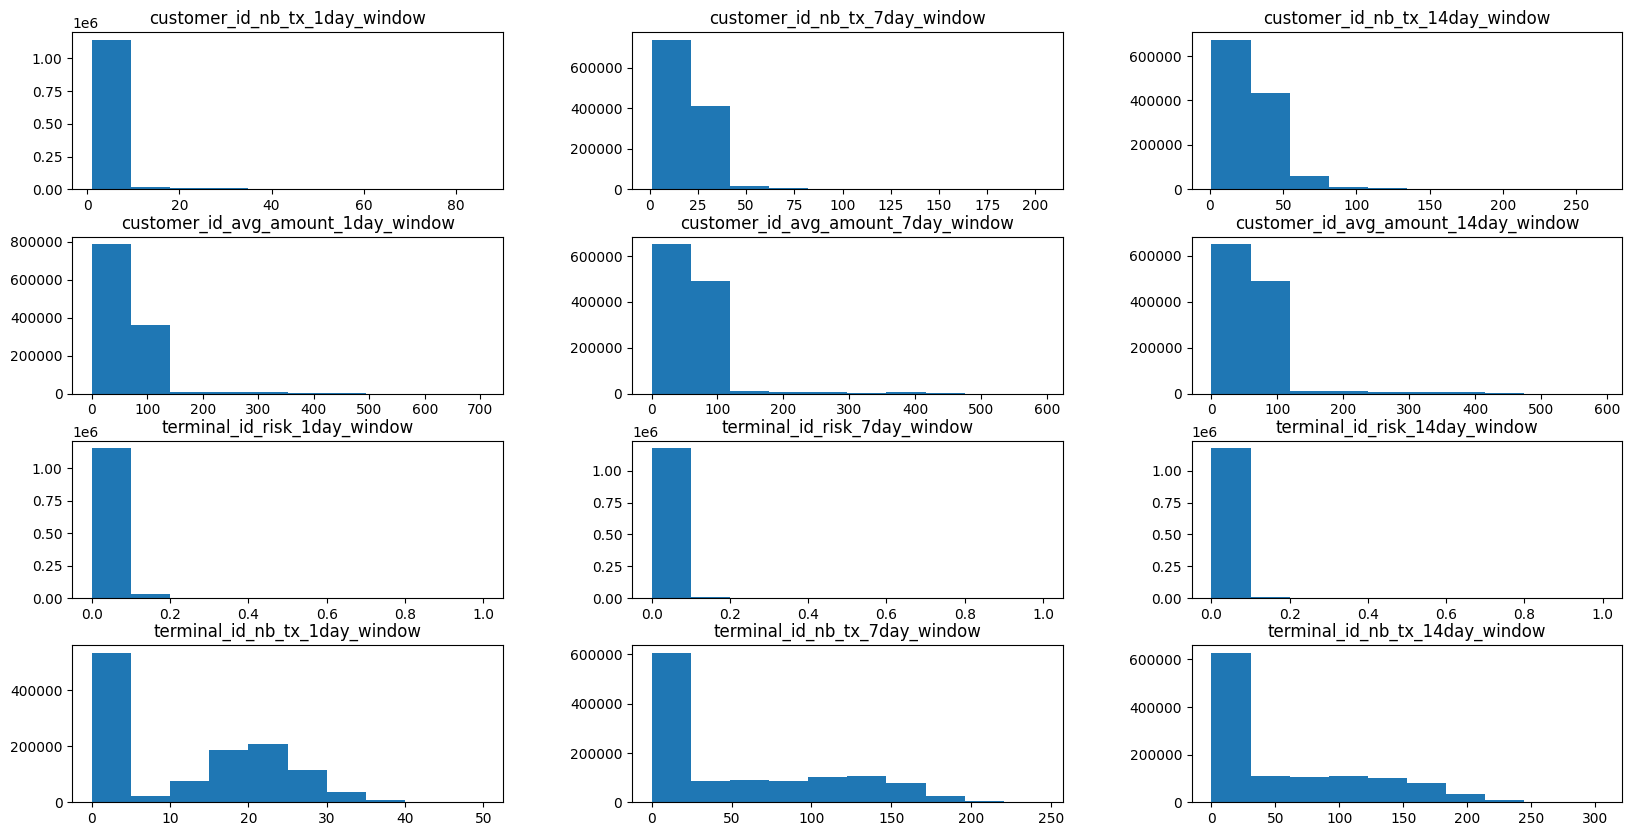

In [33]:
features = [
    "tx_amount",
    "customer_id_nb_tx_1day_window",
    "customer_id_nb_tx_7day_window",
    "customer_id_nb_tx_14day_window",
    "customer_id_avg_amount_1day_window",
    "customer_id_avg_amount_7day_window",
    "customer_id_avg_amount_14day_window",
    "terminal_id_risk_1day_window",
    "terminal_id_risk_7day_window",
    "terminal_id_risk_14day_window",
    "terminal_id_nb_tx_1day_window",
    "terminal_id_nb_tx_7day_window",
    "terminal_id_nb_tx_14day_window",
]

query_df_features[features].hist(figsize=(20, 10), grid=False)

#### Analyze the relationship between features and ```tx_fraud```
Now you can also look at the relationship between our target and input features using a correlation heatmap. 

<Axes: >

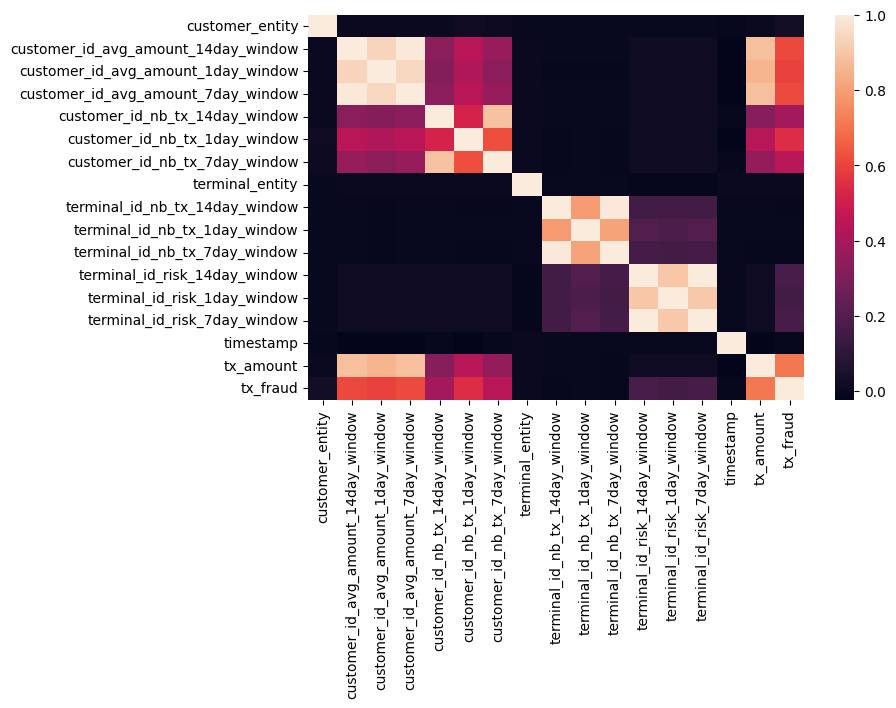

In [34]:
plt.figure(figsize=(8, 5))
sns.heatmap(query_df_features[query_df_features.columns.difference(COLUMNS_IGNORE)].corr())

##### Some observations

Based on this simple exploratory data analysis you can conclude:

- The sample data is unbalanced.
- You can probably remove some of the features with little predictive value.
- You might want to extract subsets of the timestamp into separate features such as day, week, night, etc. (i.e. calculate some time-based embeddings).
- You may want to do some variable selection.
- You might need to scale some variables.

## Building a custom fraud detection model

### Fixing an imbalanced dataset
In the real world, we must deal with an imbalance in our dataset. For example, we might randomly delete some of the non-fraudulent transactions to approximately match the number of fraudulent transactions. This technique is called undersampling.

For this workshop, we will skip the data balance process because our sample data is small already, and the further reduction will compromise the quality of our results.

In [35]:
shuffled_df = query_df_features.sample(frac=1, random_state=4)
fraud_df = shuffled_df.loc[shuffled_df["tx_fraud"] == 1]
non_fraud_df = shuffled_df.loc[shuffled_df["tx_fraud"] == 0].sample(
    n=fraud_df.shape[0], random_state=42
)
balanced_df = pd.concat([fraud_df, non_fraud_df])
(balanced_df.tx_fraud.value_counts() / balanced_df.shape[0]) * 100

tx_fraud
1    50.0
0    50.0
Name: count, dtype: float64

### Training
In this section, you will train a model using the XGBoost algorithm. As we are still experimenting, you will use the XGBoost package interactively to train your model in this notebook.

#### Why XGBoost?
The extreme gradient-boosted (XGBoost) algorithm is an ML algorithm based on ensembles of decision trees, which works well with imbalanced data, handling missing values, and can be parallelized.

#### Preparing datasets
We split our data into training, test, and validation sets in the following cell. Training data is the primary source of input for training the ML model. Validation data determines our progress after each epoch or iteration of our training loop. Finally, the test data is data the model has never seen before and is used to assess model quality at the end of the training process.

In [36]:
# Set up training variables
LABEL_COLUMN = "tx_fraud"
UNUSED_COLUMNS = ["timestamp", "customer_entity", "terminal_entity"]
NA_VALUES = ["NA", "."]

df_dataset = balanced_df
df_train, df_test, df_val = np.split(
    df_dataset.sample(frac=1, random_state=42),
    [int(0.6 * len(df_dataset)), int(0.8 * len(df_dataset))],
)

# Training set
preprocessed_train_data = preprocess(df_train)
x_train = preprocessed_train_data[
    preprocessed_train_data.columns.drop(LABEL_COLUMN).to_list()
].values
y_train = preprocessed_train_data.loc[:, LABEL_COLUMN].astype(int)

# Validation set
preprocessed_val_data = preprocess(df_val)
x_val = preprocessed_val_data[
    preprocessed_val_data.columns.drop(LABEL_COLUMN).to_list()
].values
y_val = preprocessed_val_data.loc[:, LABEL_COLUMN].astype(int)

# Test set
preprocessed_test_data = preprocess(df_test)
x_test = preprocessed_test_data[
    preprocessed_test_data.columns.drop(LABEL_COLUMN).to_list()
].values
y_test = preprocessed_test_data.loc[:, LABEL_COLUMN].astype(int)

#### Training the model
Before training the XGBoost model, you can set some hyperparameters to help us improve the model's performance. We advise you to use [Vertex AI Vizier](https://cloud.google.com/vertex-ai/docs/vizier/overview), which automates the optimization of hyperparameters, to help with hyperparameter tuning. However, in this notebook, we specify these hyperparameters manually and randomly for the sake of simplicity and expedience:

- `eta`: A regularization parameter to reduce feature weights in each boosting step.
- `gamma`: A regularization parameter for tree pruning.
- `max_depth`: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

For more information about parameters, check  [the XGBoost documentation](https://xgboost.readthedocs.io/en/stable/parameter.html).

In [41]:
parameters = [
    {"eta": 0.2, "gamma": 0.0, "max_depth": 4},
    {"eta": 0.2, "gamma": 0.0, "max_depth": 5},
    {"eta": 0.2, "gamma": 0.1, "max_depth": 4},
    {"eta": 0.2, "gamma": 0.1, "max_depth": 5},
    {"eta": 0.3, "gamma": 0.0, "max_depth": 4},
    {"eta": 0.3, "gamma": 0.0, "max_depth": 5},
    {"eta": 0.3, "gamma": 0.1, "max_depth": 4},
    {"eta": 0.3, "gamma": 0.1, "max_depth": 5},
]

models = {}
for i, params in enumerate(parameters):
    run_name = f"ff-xgboost-local-run-tt-{i}"
    print(run_name)
    vertex_ai.start_run(run=run_name)
    vertex_ai.log_params(params)
    model = xgb.XGBClassifier(
        objective="reg:logistic",
        max_depth=params["max_depth"],
        gamma=params["gamma"],
        eta=params["eta"],
        use_label_encoder=False,
    )
    model.fit(x_train, y_train)
    models[run_name] = model
    y_pred_proba = model.predict_proba(x_val)[:, 1]
    y_pred = model.predict(x_val)
    acc_score = accuracy_score(y_val, y_pred)
    val_f1_score = f1_score(y_val, y_pred, average="weighted")
    vertex_ai.log_metrics({"acc_score": acc_score, "f1score": val_f1_score})
    vertex_ai.end_run()

ff-xgboost-local-run-tt-0
Associating projects/777847327813/locations/us-central1/metadataStores/default/contexts/ff-experiment-zv7r3-ff-xgboost-local-run-tt-0 to Experiment: ff-experiment-zv7r3
ff-xgboost-local-run-tt-1
Associating projects/777847327813/locations/us-central1/metadataStores/default/contexts/ff-experiment-zv7r3-ff-xgboost-local-run-tt-1 to Experiment: ff-experiment-zv7r3
ff-xgboost-local-run-tt-2
Associating projects/777847327813/locations/us-central1/metadataStores/default/contexts/ff-experiment-zv7r3-ff-xgboost-local-run-tt-2 to Experiment: ff-experiment-zv7r3
ff-xgboost-local-run-tt-3
Associating projects/777847327813/locations/us-central1/metadataStores/default/contexts/ff-experiment-zv7r3-ff-xgboost-local-run-tt-3 to Experiment: ff-experiment-zv7r3
ff-xgboost-local-run-tt-4
Associating projects/777847327813/locations/us-central1/metadataStores/default/contexts/ff-experiment-zv7r3-ff-xgboost-local-run-tt-4 to Experiment: ff-experiment-zv7r3
ff-xgboost-local-run-tt-5

XGBoost usually performs well on imbalanced datasets. You can also try another algorithm, such as logistic regression.

We can also extract all parameters and metrics associated with any experiment into a dataframe for further analysis.

In [ ]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df.sort_values(["metric.f1score"], ascending=False)

Also, you can visualize experiments using the Cloud Console on the [Vertex AI Experiments](https://console.cloud.google.com/ai/platform/experiments/experiments) page.

#### Save model
After running the experiments, you can choose one of the experiments and use XGBoost's save_model method to export the model to a local file named `model.bst`.

In [ ]:
model_directory = "../models"
!sudo mkdir -p -m 777 {model_directory}

model = models[f"ff-xgboost-local-run-tt-{i}"]
artifact_filename = "model.bst"
model_path = os.path.join(model_directory, artifact_filename)
model.save_model(model_path)

## Model Evaluation

Let's first test the model locally on your test dataset, to get predicted labels and an F1 score, which is an aggregation of the model's precision and recall. The F1 score becomes especially valuable when working on classification models in which your data set is imbalanced. Learn more about the F1 score [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html). You will `precision_recall_fscore_support` from sklearn.

You will use test data to evaluate the model performance. First, you will take our trained XGBoost model to generate predictions on our test data. After that, you will use these predictions to calculate the F1 score and evaluate model performance. 

In [22]:
bst = xgb.Booster()
bst.load_model(model_path)
xgtest = xgb.DMatrix(x_test)
y_pred_prob = bst.predict(xgtest)
y_pred = y_pred_prob.round().astype(int)

In [23]:
# you can quickly check top five y_pred and see if we are getting labels as expected
y_pred[:5]

array([1, 1, 1, 0, 1])

In [24]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test.values, y_pred, average="weighted")

(0.9883930149802223, 0.9883364027010436, 0.9883355531334496, None)

The decision to convert a predicted probability into a fraudulent/non-fraudulent class label is determined by a discrimination threshold, which uses a default value of 0.5. A transaction is predicted as non-fraudulent (class 0) if the probability is under threshold (0.5) and fraudulent (class 1) if it is equal to or greater than the threshold (0.5). This threshold determines the True Positive (TP), False Positive (FP), True Negative (TN), and False Negative (FN) results which are typically used in the confusion matrix, precision, recall, and F1-score, all of which are used as evaluation metrics for a classification model.

You might get different TP and FP rates if you change this threshold, especially if your data needs to be balanced. By fine-tuning this threshold, you might find a value that leads to near-optimal model performance based on your business tolerance for accepting the cost of FP or FN cases. 

In the next cell, we calculate the confusion matrix for different discrimination thresholds:

Text(0.5, 0.98, 'Confusion Matrix for various thresholds')

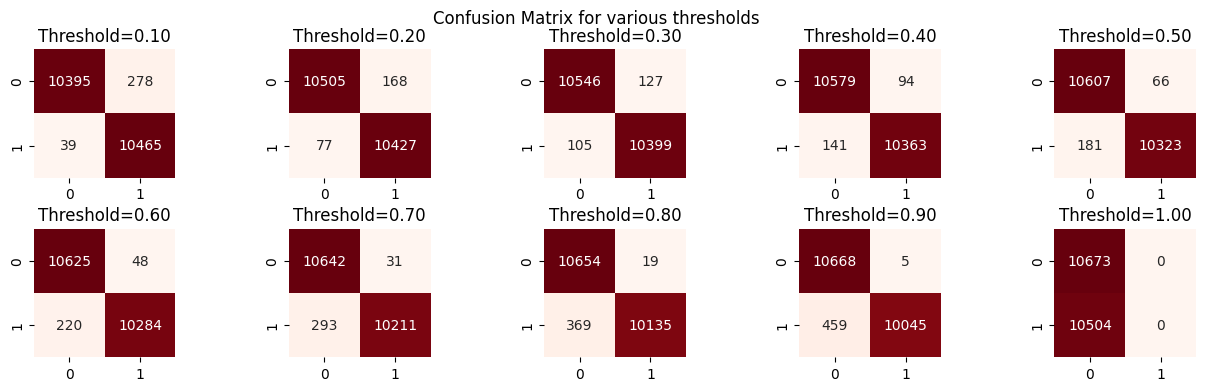

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(15, 4))

for n, ax in enumerate(axes.flat):
    threshold = (n + 1) / 10
    y_pred = (y_pred_prob > threshold).astype(int)
    cfm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cfm, annot=True, cmap="Reds", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("Threshold=%.2f" % threshold)

plt.subplots_adjust(hspace=0.4, wspace=0.8)
plt.suptitle("Confusion Matrix for various thresholds")

We might get more insight into the optimal threshold by examining a Receiver Operator Characteristic (ROC) Curve. This will plot the true positive (TP) vs. false positive (FP) rates at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve. Also, we graph the Area Under the Curve (AUC), which ranges in value from 0 to 1.0. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


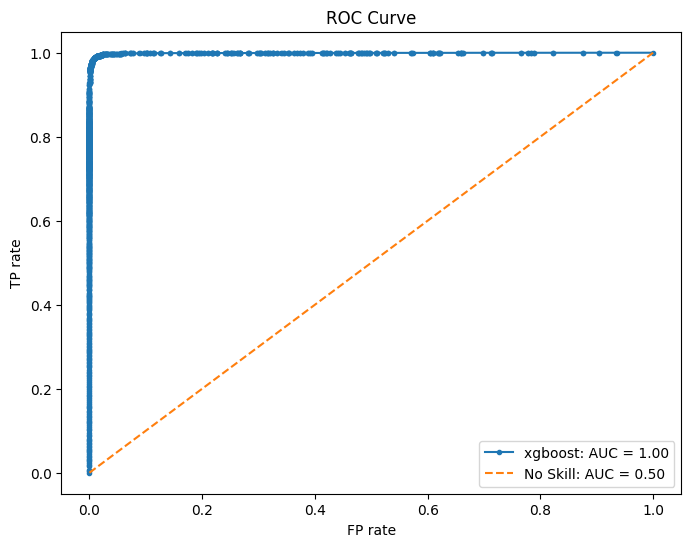

In [26]:
precision_recall_fscore_support(y_test.values, y_pred, average="weighted")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, y_pred_prob)
auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(8, 6))
# plot the roc curve for the model
plt.plot(fpr, tpr, marker=".", label="xgboost: AUC = %.2f" % auc)

# generate general prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
ns_auc = metrics.auc(ns_fpr, ns_tpr)
plt.plot(ns_fpr, ns_tpr, linestyle="--", label="No Skill: AUC = %.2f" % ns_auc)

plt.ylabel("TP rate")
plt.xlabel("FP rate")

plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

So, what is the optimal threshold? As mentioned, this depends on the business use case; for example, if we believe the optimal threshold for our use case offers the highest TPR and minimum FPR, then we can calculate the optimal threshold as follows:

In [27]:
print("Optimal threshold value is: %.3f" % thresholds[np.argmax(tpr - fpr)])

Optimal threshold value is: 0.368


Please note that the metrics may be unexpectedly high (e.g., a perfect ROC AUC score of 1.0), and that this is because the underlying data was synthetically generated. 

In practice, the evaluation metrics are likely to be lower, so this notebook focuses on the overall architecture and how tools are used together rather than on the model's actual performance.

We now understand our dataset more deeply, have achieved good results with the XGBoost algorithm, and have fine-tuned model hyperparameters. Now let's turn our attention to the following notebook to transition this training process from an manual approach to a more formalized method.

You can continue with the next notebook: `05_model_training_xgboost_formalization.ipynb`.